In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [15]:
pd.set_option("display.max_columns", None)
df = pd.read_csv('../data/modeling/reg_season_ml.csv')
df.shape

(125184, 113)

# Logistic Regression 

In [5]:
x = df.drop(columns=['Season', 'DayNum', 'Team1', 'Team2', 'Team1_Wins', 
                    'Effective_FG_Percentage_1', 'Effective_FG_Percentage_2',
                    'Conf_pac_ten_1', 'Conf_pac_ten_2', 'Conf_gwc_1', 'Conf_gwc_2', 'Conf_mid_cont_1', 'Conf_mid_cont_2'])
y = df['Team1_Wins']

# Train the model 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize the data 
scaler = StandardScaler()

# Fit on training data and transform both train & test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model
logreg = LogisticRegression(C=100)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=100)

### Feature Engineering

**Analyze which features are the most important**

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': logreg.coef_[0]
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=True)
feature_importance

,Feature,Importance
50,Win_Percentage_2,-0.879795
99,srs_rating_2,-0.614185
73,Conf_big_twelve_2,-0.280281
72,Conf_big_ten_2,-0.275963
89,Conf_sec_2,-0.265748
...,...,...
39,Conf_sec_1,0.267972
22,Conf_big_ten_1,0.279057
23,Conf_big_twelve_1,0.280453
49,srs_rating_1,0.627785


**Identify which features are highly correlated and can be removed**

In [7]:
corr_matrix = X_train.corr().abs() 
# Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation > 0.9
high_correlation = [(column, index) for column in upper.columns for index in upper.index if upper[column][index] > 0.9]

# Print correlated feature pairs
for f1, f2 in high_correlation:
    print(f"High correlation: {f1} <--> {f2} (r = {corr_matrix.loc[f1, f2]:.2f})")

High correlation: srs_rating_1 <--> Win_Percentage_1 (r = 0.91)
High correlation: srs_rating_2 <--> Win_Percentage_2 (r = 0.91)


### Model Evaluation

/Users/alexreid/Desktop/Projects/March_ML_Mania_2025/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Brier Score: 0.1649
Accuracy: 0.7163
Log Loss: 0.4943
ROC-AUC Score: 0.8370


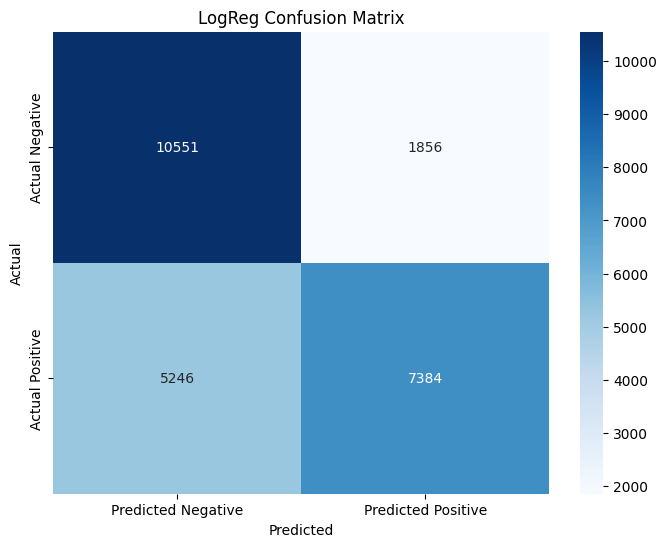

In [29]:
# Make predictions on the test set
y_pred = logreg.predict(X_test)
y_pred_probs = logreg.predict_proba(X_test_scaled)[:, 1]

brier = brier_score_loss(y_test, y_pred_probs)
print(f'Brier Score: {brier:.4f}')

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

logloss = log_loss(y_test, y_pred_probs)
print(f'Log Loss: {logloss:.4f}')

auc = roc_auc_score(y_test, y_pred_probs)
print(f'ROC-AUC Score: {auc:.4f}')

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LogReg Confusion Matrix')
plt.show()

### Outcome 
After analyzing the different solvers I identified that the defaul 'lbfgs' performed the best and worked well with the large feature set. It is also noted that setting C to 100 to implement a weaker regularization improved the model 

**Feature Importance** 

Features that were found to have minimal impact on the model include: 
  - **Conf_pac_10**: Conference rebranded to the Pac 12 with the addition of Colorado and Utah 
  - **Conf_gwc**: Great Western Conference became defunct in 2014
  - **Conf_mid_cont**: Mid Continental conference rebranded to the summit league in 2007

**Feature Correlation** 

Effective FG Percentage and FG Percentage were highly correlated, as expceted. This led me to remove Effective FG Percentage which helped increase the brier score for the model 



# K-Nearest Neighbors (k-NN)

k-NN Brier Score: 0.1861
k-NN Accuracy: 0.7105
k-NN Log Loss: 0.5692
k-NN ROC-AUC Score: 0.7915
k-NN Confusion Matrix:
[[9187 3220]
 [4028 8602]]


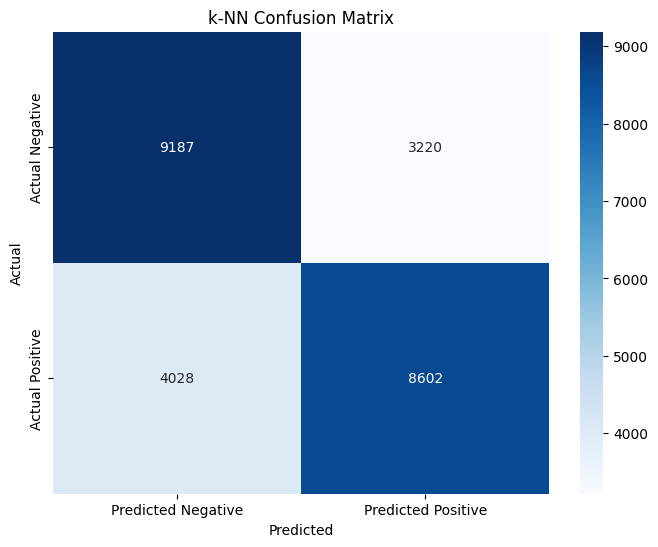

In [31]:
# k-NN model
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_scaled)
y_pred_probs_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Calculate evaluation metrics
knn_brier = brier_score_loss(y_test, y_pred_probs_knn)
print(f'k-NN Brier Score: {knn_brier:.4f}')

knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f'k-NN Accuracy: {knn_accuracy:.4f}')

knn_logloss = log_loss(y_test, y_pred_probs_knn)
print(f'k-NN Log Loss: {knn_logloss:.4f}')

knn_auc = roc_auc_score(y_test, y_pred_probs_knn)
print(f'k-NN ROC-AUC Score: {knn_auc:.4f}')

# Calculate and display the confusion matrix
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('k-NN Confusion Matrix')
plt.show()

# Decision Tree

## Ensemble 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Model evaluation
dt_score = dt.score(X_test, y_test)
print(f"Decision Tree Accuracy: {dt_score:.4f}")
